In [116]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

Configurations

In [117]:
import torch.backends

torch.set_default_device("mps:0")
device = "mps:0" # device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

batch_size = 128
noise_dim = 64


Optimizer parameters

In [118]:
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.99

Training variables

In [119]:
epochs = 20

# Load MNIST Dataset

In [120]:
from torchvision import datasets, transforms as T

In [121]:
train_augs = T.Compose([T.RandomRotation((-20, 20)),
                        T.ToTensor(), #Images need to be in channel, height, width format
])

In [122]:
trainset = datasets.MNIST(root='/Users/akshaya/Projects/DATASETS/MNIST/', train=True, download=False, transform=train_augs)

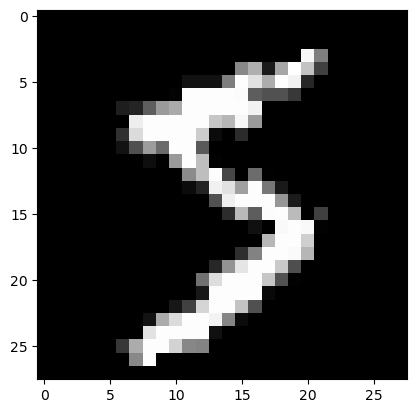

In [123]:
image, label = trainset[0]
plt.imshow(image.squeeze(), cmap='gray')

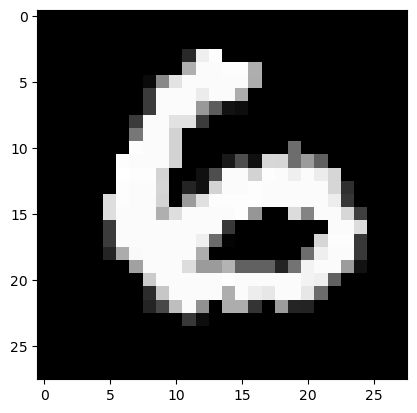

In [124]:
image, label = trainset[9000]
plt.imshow(image.squeeze(), cmap='gray')

In [125]:
print("Total number of images present on trainset from MNIST dataset: ", len(trainset))

Total number of images present on trainset from MNIST dataset:  60000


# Load Dataset into Batches 

In [126]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [127]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=False, generator=torch.Generator(device=device))

In [128]:
print("Total number of batches present in trainloader: ", len(trainloader))

Total number of batches present in trainloader:  469


In [129]:
dataiter = iter(trainloader)
images, _ = next(dataiter)
print(images.shape)

torch.Size([128, 1, 28, 28])


In [130]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

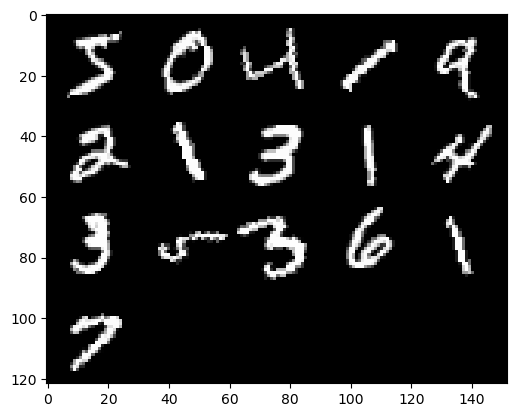

In [131]:
show_tensor_images(images, num_images=16)

# Create Discriminator Network

In [132]:
from torch import nn
from torchsummary import summary

Discriminator network structure:

1. Input
2. Conv2d, BatchNorm2d, LeakyReLU
3. Conv2d, BatchNorm2d, LeakyReLU
4. Conv2d, BatchNorm2d, LeakyReLU
5. Flatten
6. Linear Output

In [133]:
def get_disc_block(input_channels, output_channels, kernel_size=4, stride=2):
    return nn.Sequential(
        nn.Conv2d(input_channels, output_channels, kernel_size=4, stride=2),
        nn.BatchNorm2d(output_channels),
        nn.LeakyReLU(0.2)
    )

In [134]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.block_1 = get_disc_block(1, 16, (3,3), 2)
        self.block_2 = get_disc_block(16, 32, (5,5), 2)
        self.block_3 = get_disc_block(32, 64, (5,5), 2)

        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features=64, out_features=1)
    
    def forward(self, images):
        
        x1 = self.block_1(images.to(device))
        x2 = self.block_2(x1)
        x3 = self.block_3(x2)
        
        x4 = self.flatten(x3)
        x5 = self.linear(x4)

        return x5

In [135]:
D = Discriminator().to(device)

summary(D, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             272
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]           8,224
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          32,832
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 41,617
Trainable params: 41,617
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba